# Autor: Gabriel Sperb Stoffel

# Setup

## Instalação das bibliotecas

In [1]:
# Instalação das bibliotecas pandas, numpy, matplotlib, seaborn
%pip install pandas numpy matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Documentação dos arquivos

Documentação do que se trata os arquivos (contexto) e seus dados (colunas)

https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_daily_summary_files

## Criação da estrtutura de diretorios

In [2]:
# Cria a pasta data caso não exista
import os

if not os.path.exists('data'):
    os.makedirs('data')

## Download dos arquivos

Identificação do padrão para download dos arquivos.

- Ozone (44201) - https://aqs.epa.gov/aqsweb/airdata/daily_44201_{ANO}.zip
- SO2 (42401) - https://aqs.epa.gov/aqsweb/airdata/daily_42401_{ANO}.zip
- CO (42101) - https://aqs.epa.gov/aqsweb/airdata/daily_42101_{ANO}.zip
- NO2 (42602) - https://aqs.epa.gov/aqsweb/airdata/daily_42602_{ANO}.zip

Exemplo: https://aqs.epa.gov/aqsweb/airdata/daily_44201_2024.zip

In [3]:
urls_files = []

urlozone_base = 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_{year}.zip',
urlso2_base = 'https://aqs.epa.gov/aqsweb/airdata/daily_42401_{year}.zip',
urlco_base = 'https://aqs.epa.gov/aqsweb/airdata/daily_42101_{year}.zip',
urlno2_base = 'https://aqs.epa.gov/aqsweb/airdata/daily_42602_{year}.zip',

ano_inicio = 2023
ano_fim = 2024

for ano in range(ano_inicio, ano_fim+1):
    urls_files.append(urlozone_base[0].format(year=ano))
    urls_files.append(urlso2_base[0].format(year=ano))
    urls_files.append(urlco_base[0].format(year=ano))
    urls_files.append(urlno2_base[0].format(year=ano))

urls_files


['https://aqs.epa.gov/aqsweb/airdata/daily_44201_2023.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_42401_2023.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_42101_2023.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_42602_2023.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_44201_2024.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_42401_2024.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_42101_2024.zip',
 'https://aqs.epa.gov/aqsweb/airdata/daily_42602_2024.zip']

In [4]:
import urllib.request
import shutil

total_size = 0

for url in urls_files:
    # Faz uma requisição HEAD para obter os cabeçalhos
    with urllib.request.urlopen(urllib.request.Request(url, method='HEAD')) as response:
        total_size += int(response.headers.get('Content-Length', 0))

# Verifica se o tamanho do arquivo é maior que 0
if total_size == 0:
    raise Exception("Os arquivos não existem ou os tamanhos são 0.")

# Verfica se há espaço suficiente no disco
total, used, free = shutil.disk_usage("/")
total_size_MB = round(total_size / (1024 * 1024), 2)

if free < total_size:
    raise Exception(f"Espaço insuficiente no disco. \nDisponível {round(free / (1024 * 1024), 2)} MB. \nNecessário {total_size_MB} MB.")
else:
    print(f"Espaço suficiente no disco. \nDisponível {round(free / (1024 * 1024), 2)} MB. \nNecessário {total_size_MB} MB.")

Espaço suficiente no disco. 
Disponível 974537.39 MB. 
Necessário 17.58 MB.


In [5]:
import zipfile
import os

path = 'data/'

for url in urls_files:
    # Monta o caminho do arquivo
    filepath = path + url.split('/')[-1]

    # Download do arquivo
    urllib.request.urlretrieve(url, filepath)

    # Verifica se o arquivo foi baixado corretamente
    if os.path.exists(filepath):

        # Verifica se o tamanho do arquivo descompactado cabe no disco
        with zipfile.ZipFile(filepath, 'r') as zip_ref:
            for file in zip_ref.namelist():
                file_size = zip_ref.getinfo(file).file_size
                if free < file_size:
                    raise Exception(f"Espaço insuficiente no disco para descompactar o arquivo {file}. \nDisponível {round(free / (1024 * 1024), 2)} MB. \nNecessário {round(file_size / (1024 * 1024), 2)} MB.")

            # Descompacta o arquivo
            zip_ref.extractall('data')
    else:
        raise Exception("Erro no download do arquivo.")

# Organização dos arquivos em dicionario

In [6]:
import os

"""
- Ozone (44201) - https://aqs.epa.gov/aqsweb/airdata/daily_44201_{ANO}.zip
- SO2 (42401) - https://aqs.epa.gov/aqsweb/airdata/daily_42401_{ANO}.zip
- CO (42101) - https://aqs.epa.gov/aqsweb/airdata/daily_42101_{ANO}.zip
- NO2 (42602) - https://aqs.epa.gov/aqsweb/airdata/daily_42602_{ANO}.zip
"""

# Pegar lista de arquivos CSVs na pasta data
files = {
    'ozone': [],
    'so2': [],
    'co': [],
    'no2': []
}

for f in os.listdir('data'):
    if f.endswith('.csv'):
        if '44201' in f:
            files['ozone'].append('data/'+f)
        elif '42401' in f:
            files['so2'].append('data/'+f)
        elif '42101' in f:
            files['co'].append('data/'+f)
        elif '42602' in f:
            files['no2'].append('data/'+f)

# Avaliações preliminares da estrutura dos arquivos

### Tamanho do arquivo

Avaliar tamanhos dos arquivos para não gerar estouro de memória e também saber se é possível carregar o dataframe todo de uma vez ou se é necessário fazer o carregamento em partes usando o parâmetro chunksize.

In [7]:
# Tamanho total do arquivo
total_files_size = 0

ozone_size = sum([os.path.getsize(file) for file in files['ozone']])
so2_size = sum([os.path.getsize(file) for file in files['so2']])
co_size = sum([os.path.getsize(file) for file in files['co']])
no2_size = sum([os.path.getsize(file) for file in files['no2']])
total_files_size = ozone_size + so2_size + co_size + no2_size

ozone_size_MB = round(ozone_size / (1024 * 1024), 2)
so2_size_MB = round(so2_size / (1024 * 1024), 2)
co_size_MB = round(co_size / (1024 * 1024), 2)
no2_size_MB = round(no2_size / (1024 * 1024), 2)
total_files_size_MB = round(total_files_size / (1024 * 1024), 2)

print(f"Tamanho do arquivo Ozone: {ozone_size_MB} MB")
print(f"Tamanho do arquivo SO2: {so2_size_MB} MB")
print(f"Tamanho do arquivo CO: {co_size_MB} MB")
print(f"Tamanho do arquivo NO2: {no2_size_MB} MB")
print(f"Tamanho total dos arquivos: {total_files_size_MB} MB")

Tamanho do arquivo Ozone: 207.3 MB
Tamanho do arquivo SO2: 142.63 MB
Tamanho do arquivo CO: 86.94 MB
Tamanho do arquivo NO2: 83.04 MB
Tamanho total dos arquivos: 519.9 MB


### Estrutura (RAW) do arquivo - Cabeçalho, 2 primeiras e 2 últimas linhas

Importante avaliar as colunas do arquivo, os tipos de dados, se as colunas estão completas, e se existem colunas que não são necessárias para a análise.

Ao carregar o dataframe através do pandas, ele já faz uma avaliação inicial dos tipos de dados, mas é importante fazer essa avaliação manual também, pois ele pode inferir tipos de dados errados, já que se baseia nas primeira linhas.

A primeira linha deve ser obrigatoriamente o cabeçalho, e as demais linhas devem ser os dados. Caso o arquivo tenha mais de uma linha de cabeçalho, é necessário usar o parâmetro header=1 ou header=2, por exemplo.

In [8]:
for pollutant, filepath in files.items():

    title = '\nPoluente - ' + pollutant + ':'
    print(title)
    print('-' * len(title))

    with open(filepath[0], 'r') as file:
        # Lê as primeiras 5 e 5 ultimas linhas do arquivo
        lines = file.readlines()

        print("Cabeçalho do arquivo:")
        for line in lines[:1]:
            print(line.strip())

        print("\nPrimeiras 2 linhas do arquivo:")
        for line in lines[1:3]:
            print(line.strip())

        print("\nUltimas 5 linhas do arquivo:")
        for line in lines[-2:]:
            print(line.strip())
        print('\n' + '-'*100)


Poluente - ozone:
------------------
Cabeçalho do arquivo:
"State Code","County Code","Site Num","Parameter Code","POC","Latitude","Longitude","Datum","Parameter Name","Sample Duration","Pollutant Standard","Date Local","Units of Measure","Event Type","Observation Count","Observation Percent","Arithmetic Mean","1st Max Value","1st Max Hour","AQI","Method Code","Method Name","Local Site Name","Address","State Name","County Name","City Name","CBSA Name","Date of Last Change"

Primeiras 2 linhas do arquivo:
"01","003","0010","44201",1,30.497478,-87.880258,"NAD83","Ozone","8-HR RUN AVG BEGIN HOUR","Ozone 8-hour 2015","2024-02-29","Parts per million","None",2,12.0,0.032,0.032,23,30,"047","INSTRUMENTAL - ULTRA VIOLET","FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE,  ALABAMA","Alabama","Baldwin","Fairhope","Daphne-Fairhope-Foley, AL","2024-10-31"
"01","003","0010","44201",1,30.497478,-87.880258,"NAD83","Ozone","8-HR RUN AVG BEGIN HOUR","Ozone 8-hour 2015","2024-03-01","P

# Pandas

## Setup

In [98]:
import pandas as pd

# Configuração do pandas para exibir todas as colunas
pd.set_option('display.max_columns', None)
# Configuração do pandas para exibir todas as linhas
pd.set_option('display.max_rows', None)

## Load Dataframes

In [99]:
"""
- Carregando files usando o low_memory=False para evitar problemas de inferência errada em tipos de dados
- Usando o assign para adicionar o nome do arquivo a uma nova coluna.
- É importante avaliar se os dados da coluna "Date Local" são coerentes com o nome do arquivo, já que os dados dizem ser de determinada data. Caso for diferente, pode indicar inconsistências ou dados incorretos.
"""

# Importar através do link direto e sem extrair
# pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_44201_2024.zip', compression='zip', low_memory=False)

df_ozone = pd.concat([
    pd.read_csv(file, parse_dates=['Date Local', 'Date of Last Change'], low_memory=False).assign(file_name=os.path.basename(file))
    for file in files['ozone']
])

df_so2 = pd.concat([
    pd.read_csv(file, parse_dates=['Date Local', 'Date of Last Change'], low_memory=False).assign(file_name=os.path.basename(file))
    for file in files['so2']
])

df_co = pd.concat([
    pd.read_csv(file, parse_dates=['Date Local', 'Date of Last Change'], low_memory=False).assign(file_name=os.path.basename(file))
    for file in files['co']
])

df_no2 = pd.concat([
    pd.read_csv(file, parse_dates=['Date Local', 'Date of Last Change'], low_memory=False).assign(file_name=os.path.basename(file))
    for file in files['no2']
])

Verificar se todos possuem as mesmas colunas e tipos de dados antes de juntar todos em 1 só DF

In [100]:
df_ozone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 627652 entries, 0 to 388237
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   State Code           627652 non-null  int64         
 1   County Code          627652 non-null  int64         
 2   Site Num             627652 non-null  int64         
 3   Parameter Code       627652 non-null  int64         
 4   POC                  627652 non-null  int64         
 5   Latitude             627652 non-null  float64       
 6   Longitude            627652 non-null  float64       
 7   Datum                627652 non-null  object        
 8   Parameter Name       627652 non-null  object        
 9   Sample Duration      627652 non-null  object        
 10  Pollutant Standard   627652 non-null  object        
 11  Date Local           627652 non-null  datetime64[ns]
 12  Units of Measure     627652 non-null  object        
 13  Event Type         

In [101]:
df_so2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 442925 entries, 0 to 283302
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   State Code           442925 non-null  int64         
 1   County Code          442925 non-null  int64         
 2   Site Num             442925 non-null  int64         
 3   Parameter Code       442925 non-null  int64         
 4   POC                  442925 non-null  int64         
 5   Latitude             442925 non-null  float64       
 6   Longitude            442925 non-null  float64       
 7   Datum                442925 non-null  object        
 8   Parameter Name       442925 non-null  object        
 9   Sample Duration      442925 non-null  object        
 10  Pollutant Standard   442925 non-null  object        
 11  Date Local           442925 non-null  datetime64[ns]
 12  Units of Measure     442925 non-null  object        
 13  Event Type         

In [102]:
df_co.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250951 entries, 0 to 89792
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   State Code           250951 non-null  int64         
 1   County Code          250951 non-null  int64         
 2   Site Num             250951 non-null  int64         
 3   Parameter Code       250951 non-null  int64         
 4   POC                  250951 non-null  int64         
 5   Latitude             250951 non-null  float64       
 6   Longitude            250951 non-null  float64       
 7   Datum                250951 non-null  object        
 8   Parameter Name       250951 non-null  object        
 9   Sample Duration      250951 non-null  object        
 10  Pollutant Standard   250951 non-null  object        
 11  Date Local           250951 non-null  datetime64[ns]
 12  Units of Measure     250951 non-null  object        
 13  Event Type          

In [103]:
df_no2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243286 entries, 0 to 156365
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   State Code           243286 non-null  int64         
 1   County Code          243286 non-null  int64         
 2   Site Num             243286 non-null  int64         
 3   Parameter Code       243286 non-null  int64         
 4   POC                  243286 non-null  int64         
 5   Latitude             243286 non-null  float64       
 6   Longitude            243286 non-null  float64       
 7   Datum                243286 non-null  object        
 8   Parameter Name       243286 non-null  object        
 9   Sample Duration      243286 non-null  object        
 10  Pollutant Standard   243286 non-null  object        
 11  Date Local           243286 non-null  datetime64[ns]
 12  Units of Measure     243286 non-null  object        
 13  Event Type         

In [104]:
# Juntando todos os dataframes em um só
df_all = pd.concat([df_ozone, df_so2, df_co, df_no2], ignore_index=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564814 entries, 0 to 1564813
Data columns (total 30 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   State Code           1564814 non-null  int64         
 1   County Code          1564814 non-null  int64         
 2   Site Num             1564814 non-null  int64         
 3   Parameter Code       1564814 non-null  int64         
 4   POC                  1564814 non-null  int64         
 5   Latitude             1564814 non-null  float64       
 6   Longitude            1564814 non-null  float64       
 7   Datum                1564814 non-null  object        
 8   Parameter Name       1564814 non-null  object        
 9   Sample Duration      1564814 non-null  object        
 10  Pollutant Standard   1564814 non-null  object        
 11  Date Local           1564814 non-null  datetime64[ns]
 12  Units of Measure     1564814 non-null  object        
 1

In [105]:
# Liberando espaço da memória
del df_co
del df_no2
del df_so2
del df_ozone

In [106]:
# Teste de extração do ano do nome do arquivo (daily_44201_2023.csv -> 2023)
df_all['file_name'].str.extract(r'_(\d{4})\.csv')[0].head()

0    2024
1    2024
2    2024
3    2024
4    2024
Name: 0, dtype: object

In [107]:
# Extrair o ano do nome do arquivo (daily_44201_2023.csv -> 2023)
# df_ozone['file_year'] = df_ozone['file_name'].str.extract(r'_(\d{4})\.csv')[0]
# df_so2['file_year'] = df_so2['file_name'].str.extract(r'_(\d{4})\.csv')[0]
# df_co['file_year'] = df_co['file_name'].str.extract(r'_(\d{4})\.csv')[0]
# df_no2['file_year'] = df_no2['file_name'].str.extract(r'_(\d{4})\.csv')[0]
df_all['file_year'] = df_all['file_name'].str.extract(r'_(\d{4})\.csv')[0]

## Avaliação incial da estrutura do dataframe

### Head / Tail / Sample

Avaliando as 5 primeiras e 5 últimas linhas do dataframe, e também uma amostra aleatória de 10 linhas.

A amostra aleatória é importante para avaliar se os dados estão coerentes e se não há problemas de inconsistências nos dados, ou agrupamentos desbalanceados de dados

In [108]:
pd.concat([df_all.head(3), df_all.tail(3), df_all.sample(5)])

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,Pollutant Standard,Date Local,Units of Measure,Event Type,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change,file_name,file_year
0,1,3,10,44201,1,30.497478,-87.880258,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2024-02-29,Parts per million,NaN,2,12.0,0.032000,0.032,23,30.0,47.0,INSTRUMENTAL - ULTRA VIOLET,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2024-10-31,daily_44201_2024.csv,2024
1,1,3,10,44201,1,30.497478,-87.880258,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2024-03-01,Parts per million,NaN,34,200.0,0.024706,0.030,12,28.0,47.0,INSTRUMENTAL - ULTRA VIOLET,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2024-10-31,daily_44201_2024.csv,2024
2,1,3,10,44201,1,30.497478,-87.880258,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2024-03-02,Parts per million,NaN,34,200.0,0.013118,0.016,18,15.0,47.0,INSTRUMENTAL - ULTRA VIOLET,"FAIRHOPE, Alabama","FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",Alabama,Baldwin,Fairhope,"Daphne-Fairhope-Foley, AL",2024-10-31,daily_44201_2024.csv,2024
1564811,72,25,7,42602,1,18.198712,-66.052237,NAD83,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,2023-03-05,Parts per billion,NaN,24,100.0,3.266667,9.000,20,8.0,599.0,Instrumental - Chemiluminescence Teledyne API ...,NaN,Luis A. Ferre Highway,Puerto Rico,Caguas,Caguas,"San Juan-Carolina-Caguas, PR",2024-05-22,daily_42602_2023.csv,2023
1564812,72,25,7,42602,1,18.198712,-66.052237,NAD83,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,2023-03-06,Parts per billion,NaN,24,100.0,4.516667,8.800,10,8.0,599.0,Instrumental - Chemiluminescence Teledyne API ...,NaN,Luis A. Ferre Highway,Puerto Rico,Caguas,Caguas,"San Juan-Carolina-Caguas, PR",2024-05-22,daily_42602_2023.csv,2023
1564813,72,25,7,42602,1,18.198712,-66.052237,NAD83,Nitrogen dioxide (NO2),1 HOUR,NO2 1-hour 2010,2023-03-07,Parts per billion,NaN,11,46.0,5.436364,19.300,9,18.0,599.0,Instrumental - Chemiluminescence Teledyne API ...,NaN,Luis A. Ferre Highway,Puerto Rico,Caguas,Caguas,"San Juan-Carolina-Caguas, PR",2024-05-22,daily_42602_2023.csv,2023
623997,56,35,101,44201,1,42.869824,-109.870760,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2023-12-25,Parts per million,NaN,17,100.0,0.032176,0.041,7,38.0,87.0,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Pinedale Gaseous,Pinedale Gaseous Monitor on west side of City ...,Wyoming,Sublette,Not in a city,NaN,2024-05-25,daily_44201_2023.csv,2023
1256397,12,11,34,42101,1,26.053889,-80.256944,WGS84,Carbon monoxide,8-HR RUN AVG END HOUR,CO 8-hour 1971,2024-06-22,Parts per million,NaN,24,100.0,0.137500,0.200,5,2.0,554.0,INSTRUMENTAL - Gas Filter Correlation Thermo E...,Daniela Banu NCORE,"5300 South Pine Island Road, Davie, FL 33328",Florida,Broward,Davie,"Miami-Fort Lauderdale-West Palm Beach, FL",2024-08-30,daily_42101_2024.csv,2024
114546,25,21,2005,44201,1,42.241229,-70.963346,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,Ozone 8-hour 2015,2024-04-18,Parts per million,NaN,17,100.0,0.034529,0.036,7,33.0,87.0,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,NaN,59 Monatiquot St,Massachusetts,Norfolk,Weymouth,"Boston-Cambridge-Newton, MA-NH",2024-11-01,daily_44201_2024.csv,2024
1214368,49,35,3006,42101,1,40.736389,-111.872222,WGS84,Carbon monoxide,8-HR RUN AVG END HOUR,CO 8-hour 1971,2023-07-31,Parts per million,NaN,24,100.0,0.054167,0.100,7,1.0,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,Hawthorne,"1675 SOUTH 600 EAST, SALT LAKE CITY",Utah,Salt Lake,Salt Lake City,"Salt Lake City, UT",2024-05-09,daily_42101_2023.csv,2023


- Todos os arquivos apresentam as 30 colunas 
- Possuem as seguintes mesmas colunas
- As seguinte colunas tem valores nulos em todos os arquivos:
  - Event Type: Indicates whether data measured during exceptional events are included in the summary.
  - AQI: The Air Quality Index for the day for the pollutant, if applicable.
  - Local Site Name: The name of the site (if any) given by the State, local, or tribal air pollution control agency that operates it.
  - Address: The approximate street address of the monitoring site.
  - CBSA Name: The name of the core bases statistical area (metropolitan area) where the monitoring site is located.

A coluna "Method Code" apresenta valores nulos apenas nos arquivos Ozonio e Co, e conforme a documentação:
- Method Code:
An internal system code indicating the method (processes, equipment, and protocols) used in gathering and measuring the sample. The method name is in the next column.

Verificado que em alguns casos o Method Name é preenchido enquanto a Method Code está NaN (nulo). Necessário uma análise para entender estes registros.

### Reorganização das colunas

É mais fácil de analisar a olho humano dados e colunas que sejam nome representativos, do que IDS, então para isso, é importante reordenar as colunas do conjunto de dados para que façam sentido com as análise pensadas.

Exemplo: ao invés de "State Code" como 1ª coluna e o "State Name" como 24ª, é melhor ordernar de forma que uma esteja próxima a outra, ou até mesmo que o Nome venha antes da coluna de ID

Como as colunas seguem um padrão de nomenclatura, poderiamos apenas fazer um sort delas, para ordenar por nome, isso já faria com que colunas de mesmo contexto estivessem lado a lado

In [109]:
sorted(list(df_all.columns))

['1st Max Hour',
 '1st Max Value',
 'AQI',
 'Address',
 'Arithmetic Mean',
 'CBSA Name',
 'City Name',
 'County Code',
 'County Name',
 'Date Local',
 'Date of Last Change',
 'Datum',
 'Event Type',
 'Latitude',
 'Local Site Name',
 'Longitude',
 'Method Code',
 'Method Name',
 'Observation Count',
 'Observation Percent',
 'POC',
 'Parameter Code',
 'Parameter Name',
 'Pollutant Standard',
 'Sample Duration',
 'Site Num',
 'State Code',
 'State Name',
 'Units of Measure',
 'file_name',
 'file_year']

In [110]:
columns_reorder = [
    'Parameter Name',
    'Date Local',
    'Date of Last Change',
    'CBSA Name',
    'County Name',
    'State Name',
    'City Name',
    'Address',
    'Observation Count',
    'Observation Percent',
    '1st Max Hour',
    '1st Max Value',
    'AQI',
    'Arithmetic Mean',
    'Event Type',
    'Local Site Name',
    'Method Name',
    'POC',
    'Pollutant Standard',
    'Sample Duration',
    'Units of Measure',
    
    'Latitude',
    'Longitude',
    'Datum',
    'County Code',
    'State Code',
    'Method Code',
    'Parameter Code',
    'Site Num',
    'file_name',
    'file_year'
]

df_all = df_all[columns_reorder]
df_all.head(3)

,Parameter Name,Date Local,Date of Last Change,CBSA Name,County Name,State Name,City Name,Address,Observation Count,Observation Percent,1st Max Hour,1st Max Value,AQI,Arithmetic Mean,Event Type,Local Site Name,Method Name,POC,Pollutant Standard,Sample Duration,Units of Measure,Latitude,Longitude,Datum,County Code,State Code,Method Code,Parameter Code,Site Num,file_name,file_year
0,Ozone,2024-02-29,2024-10-31,"Daphne-Fairhope-Foley, AL",Baldwin,Alabama,Fairhope,"FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",2,12.0,23,0.032,30.0,0.032000,NaN,"FAIRHOPE, Alabama",INSTRUMENTAL - ULTRA VIOLET,1,Ozone 8-hour 2015,8-HR RUN AVG BEGIN HOUR,Parts per million,30.497478,-87.880258,NAD83,3,1,47.0,44201,10,daily_44201_2024.csv,2024
1,Ozone,2024-03-01,2024-10-31,"Daphne-Fairhope-Foley, AL",Baldwin,Alabama,Fairhope,"FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",34,200.0,12,0.030,28.0,0.024706,NaN,"FAIRHOPE, Alabama",INSTRUMENTAL - ULTRA VIOLET,1,Ozone 8-hour 2015,8-HR RUN AVG BEGIN HOUR,Parts per million,30.497478,-87.880258,NAD83,3,1,47.0,44201,10,daily_44201_2024.csv,2024
2,Ozone,2024-03-02,2024-10-31,"Daphne-Fairhope-Foley, AL",Baldwin,Alabama,Fairhope,"FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",34,200.0,18,0.016,15.0,0.013118,NaN,"FAIRHOPE, Alabama",INSTRUMENTAL - ULTRA VIOLET,1,Ozone 8-hour 2015,8-HR RUN AVG BEGIN HOUR,Parts per million,30.497478,-87.880258,NAD83,3,1,47.0,44201,10,daily_44201_2024.csv,2024


## Correções de valores e tipos

In [111]:
df_all[df_all['Method Code'].isnull()][['Method Code', 'Method Name']].sample()

,Method Code,Method Name
91802,NaN,-


Avaliado que os registros os quais a coluna Method Code está nula (NaN) o Method Name tem valores "-", o que representa que não há nome, então não há uma real necessidade de tratamento. Mas pode ser interessante substituir o "-" por NA para facilitar a visualização e tratamento futuro.

In [112]:
df_all['Method Name'] = df_all['Method Name'].str.strip().replace('-', pd.NA)

In [113]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564814 entries, 0 to 1564813
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Parameter Name       1564814 non-null  object        
 1   Date Local           1564814 non-null  datetime64[ns]
 2   Date of Last Change  1564814 non-null  datetime64[ns]
 3   CBSA Name            1437745 non-null  object        
 4   County Name          1564814 non-null  object        
 5   State Name           1564814 non-null  object        
 6   City Name            1564814 non-null  object        
 7   Address              1563357 non-null  object        
 8   Observation Count    1564814 non-null  int64         
 9   Observation Percent  1564814 non-null  float64       
 10  1st Max Hour         1564814 non-null  int64         
 11  1st Max Value        1564814 non-null  float64       
 12  AQI                  1218193 non-null  float64       
 1

### Validação do ano do arquivo vs ano da coluna Date Local

In [114]:
df_all[['Date Local']].head()

,Date Local
0,2024-02-29
1,2024-03-01
2,2024-03-02
3,2024-03-03
4,2024-03-04


In [115]:
df_all['Date Local'].dt.year.astype(str).head()

0    2024
1    2024
2    2024
3    2024
4    2024
Name: Date Local, dtype: object

In [116]:
df_all[['file_year']].head()

,file_year
0,2024
1,2024
2,2024
3,2024
4,2024


In [117]:
df_all[df_all['Date Local'].dt.year.astype(str) != df_all['file_year']].shape

(0, 31)

### Correção das escalas, partes por bilhão

In [118]:
df_all.head()

,Parameter Name,Date Local,Date of Last Change,CBSA Name,County Name,State Name,City Name,Address,Observation Count,Observation Percent,1st Max Hour,1st Max Value,AQI,Arithmetic Mean,Event Type,Local Site Name,Method Name,POC,Pollutant Standard,Sample Duration,Units of Measure,Latitude,Longitude,Datum,County Code,State Code,Method Code,Parameter Code,Site Num,file_name,file_year
0,Ozone,2024-02-29,2024-10-31,"Daphne-Fairhope-Foley, AL",Baldwin,Alabama,Fairhope,"FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",2,12.0,23,0.032,30.0,0.032000,NaN,"FAIRHOPE, Alabama",INSTRUMENTAL - ULTRA VIOLET,1,Ozone 8-hour 2015,8-HR RUN AVG BEGIN HOUR,Parts per million,30.497478,-87.880258,NAD83,3,1,47.0,44201,10,daily_44201_2024.csv,2024
1,Ozone,2024-03-01,2024-10-31,"Daphne-Fairhope-Foley, AL",Baldwin,Alabama,Fairhope,"FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",34,200.0,12,0.030,28.0,0.024706,NaN,"FAIRHOPE, Alabama",INSTRUMENTAL - ULTRA VIOLET,1,Ozone 8-hour 2015,8-HR RUN AVG BEGIN HOUR,Parts per million,30.497478,-87.880258,NAD83,3,1,47.0,44201,10,daily_44201_2024.csv,2024
2,Ozone,2024-03-02,2024-10-31,"Daphne-Fairhope-Foley, AL",Baldwin,Alabama,Fairhope,"FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",34,200.0,18,0.016,15.0,0.013118,NaN,"FAIRHOPE, Alabama",INSTRUMENTAL - ULTRA VIOLET,1,Ozone 8-hour 2015,8-HR RUN AVG BEGIN HOUR,Parts per million,30.497478,-87.880258,NAD83,3,1,47.0,44201,10,daily_44201_2024.csv,2024
3,Ozone,2024-03-03,2024-10-31,"Daphne-Fairhope-Foley, AL",Baldwin,Alabama,Fairhope,"FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",34,200.0,11,0.039,36.0,0.033941,NaN,"FAIRHOPE, Alabama",INSTRUMENTAL - ULTRA VIOLET,1,Ozone 8-hour 2015,8-HR RUN AVG BEGIN HOUR,Parts per million,30.497478,-87.880258,NAD83,3,1,47.0,44201,10,daily_44201_2024.csv,2024
4,Ozone,2024-03-04,2024-10-31,"Daphne-Fairhope-Foley, AL",Baldwin,Alabama,Fairhope,"FAIRHOPE HIGH SCHOOL, 1 PIRATE DRIVE, FAIRHOPE...",34,200.0,23,0.039,36.0,0.032471,NaN,"FAIRHOPE, Alabama",INSTRUMENTAL - ULTRA VIOLET,1,Ozone 8-hour 2015,8-HR RUN AVG BEGIN HOUR,Parts per million,30.497478,-87.880258,NAD83,3,1,47.0,44201,10,daily_44201_2024.csv,2024


In [119]:
df_all.columns

Index(['Parameter Name', 'Date Local', 'Date of Last Change', 'CBSA Name',
       'County Name', 'State Name', 'City Name', 'Address',
       'Observation Count', 'Observation Percent', '1st Max Hour',
       '1st Max Value', 'AQI', 'Arithmetic Mean', 'Event Type',
       'Local Site Name', 'Method Name', 'POC', 'Pollutant Standard',
       'Sample Duration', 'Units of Measure', 'Latitude', 'Longitude', 'Datum',
       'County Code', 'State Code', 'Method Code', 'Parameter Code',
       'Site Num', 'file_name', 'file_year'],
      dtype='object')

In [120]:
df_all['Units of Measure'].unique()

array(['Parts per million', 'Parts per billion'], dtype=object)

In [121]:
# Nas linhas onde a unidade de medida é "Parts per billion", deve dividir por 1000
df_all.loc[df_all['Units of Measure'] == 'Parts per billion', 'Arithmetic Mean'] = df_all.loc[df_all['Units of Measure'] == 'Parts per billion', 'Arithmetic Mean'] / 1000

In [122]:
df_all['Units of Measure'] = df_all['Units of Measure'].replace('Parts per billion', 'Parts per million')

In [123]:
df_all[['Units of Measure', 'Arithmetic Mean']].head(5)

,Units of Measure,Arithmetic Mean
0,Parts per million,0.032000
1,Parts per million,0.024706
2,Parts per million,0.013118
3,Parts per million,0.033941
4,Parts per million,0.032471


### Describe

Verificar valores e validar se há outliers

In [124]:
df_all.describe().T

,count,mean,min,25%,50%,75%,max,std
Date Local,1564814,2023-10-21 01:28:47.455403264,2023-01-01 00:00:00,2023-05-27 00:00:00,2023-10-10 00:00:00,2024-03-18 00:00:00,2024-11-01 00:00:00,NaN
Date of Last Change,1564814,2024-07-05 16:55:38.730864896,2023-06-16 00:00:00,2024-05-09 00:00:00,2024-05-25 00:00:00,2024-10-01 00:00:00,2024-11-20 00:00:00,NaN
Observation Count,1564814.0,22.769861,1.0,17.0,22.0,24.0,504.0,20.357218
Observation Percent,1564814.0,124.271174,4.0,100.0,100.0,100.0,2500.0,122.834761
1st Max Hour,1564814.0,9.911099,0.0,6.0,10.0,12.0,23.0,6.140395
1st Max Value,1564814.0,3.289689,-3.3,0.042,0.2,1.1,1452.9,12.204618
AQI,1218193.0,25.564413,0.0,4.0,26.0,40.0,291.0,22.679437
Arithmetic Mean,1564814.0,0.058559,-0.4,0.001125,0.022941,0.041824,4.375,0.115308
POC,1564814.0,1.172566,1.0,1.0,1.0,1.0,9.0,0.659719
Latitude,1564814.0,37.704045,17.967309,34.10002,38.595607,41.221418,64.84569,5.42857


### Corrigindo dados negativos

Verificado que há dados negativos, o que não faz sentido, por isso serão removido essas observações

In [126]:
# Substituindo valores negativos na coluna Arithmetic Mean e 1st Max Value por NA usando where
df_all['Arithmetic Mean'] = df_all['Arithmetic Mean'].where(df_all['Arithmetic Mean'] >= 0, pd.NA)
df_all['1st Max Value'] = df_all['1st Max Value'].where(df_all['1st Max Value'] >= 0, pd.NA)
df_all[['Arithmetic Mean', '1st Max Value']].describe().T

,count,mean,std,min,25%,50%,75%,max
Arithmetic Mean,1526688.0,0.060144,0.116214,0.0,0.001375,0.024118,0.042412,4.375
1st Max Value,1550721.0,3.322573,12.255018,0.0,0.043000,0.200000,1.200000,1452.900


# Plotando Gráficos

## Gráfico 1 - Entendendo os dados

Primeiro Gráfico para entender como está a distribuição e como podemos validar os dados

In [139]:
# Importando as bibliotecas necessárias
import matplotlib.pyplot as plt
import seaborn as sns

In [140]:
# "County Name = Humboldt", "State Name = California", "City Name = Eureka"
df_ozone_Eureka = df_all[(df_all['County Name'] == 'Humboldt') & (df_all['State Name'] == 'California') & (df_all['City Name'] == 'Eureka') & (df_all['Parameter Name'] == 'Ozone')]

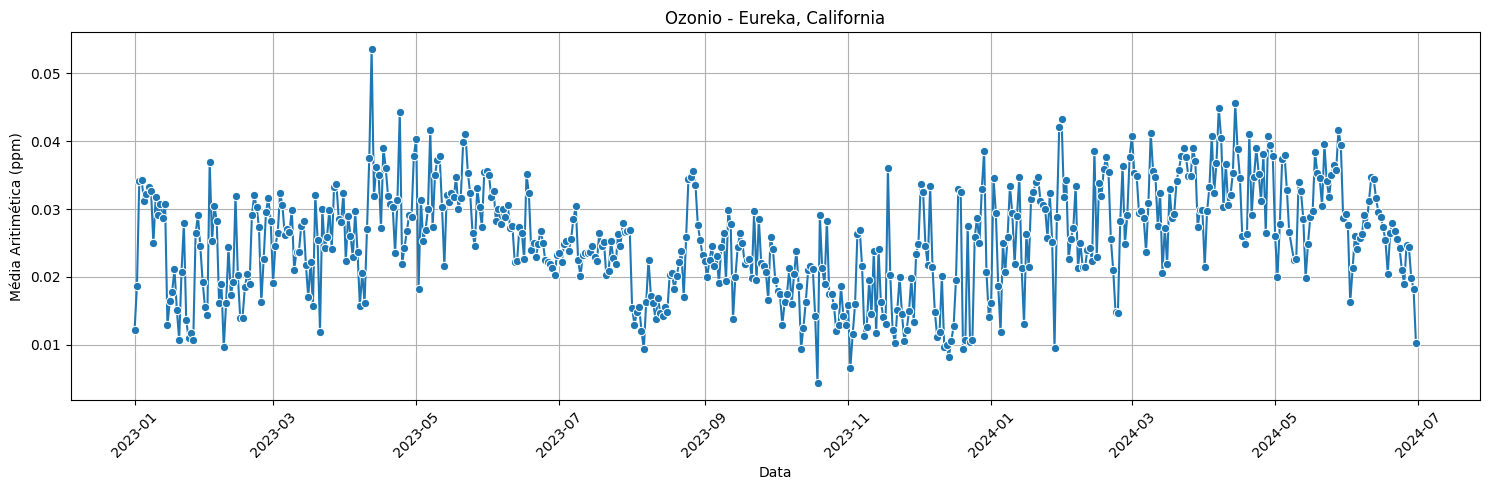

In [141]:
# plotando grafico da cidade de Eureka
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_ozone_Eureka, x='Date Local', y='Arithmetic Mean', marker='o')
plt.title('Ozonio - Eureka, California')
plt.xlabel('Data')
plt.ylabel('Média Aritimética (ppm)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

## Gráfico 2 - Verificando todos os poluentes

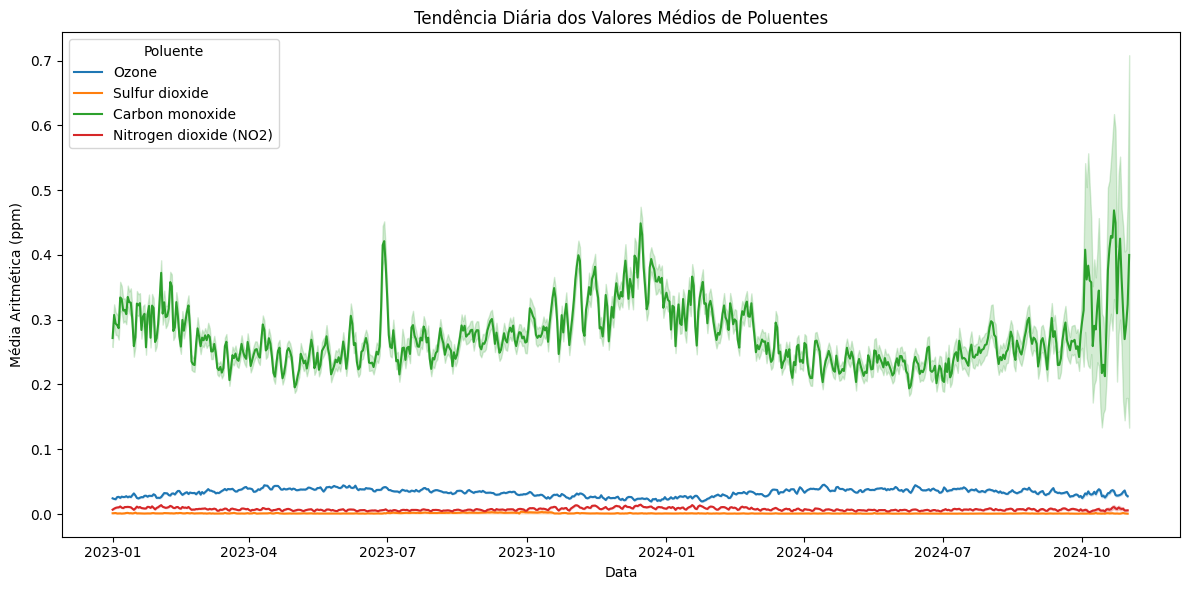

In [142]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_all, x='Date Local', y='Arithmetic Mean', hue='Parameter Name')
plt.title('Tendência Diária dos Valores Médios de Poluentes')
plt.xlabel('Data')
plt.ylabel('Média Aritmética (ppm)')
plt.legend(title='Poluente')
plt.tight_layout()
plt.show()

Neste a cima podemos ver os dados de todas as cidades, vamos fazer a média da média de todos os locais para ver melhor como se comporta, sabendo que o monóxido de carbono é muito superior aos demais

In [143]:
df_media_geral = (
    df_all
    .groupby(['Date Local', 'Parameter Name'])['Arithmetic Mean']
    .mean()
    .reset_index()
)
df_media_geral.head()

,Date Local,Parameter Name,Arithmetic Mean
0,2023-01-01,Carbon monoxide,0.271693
1,2023-01-01,Nitrogen dioxide (NO2),0.006723
2,2023-01-01,Ozone,0.024211
3,2023-01-01,Sulfur dioxide,0.001163
4,2023-01-02,Carbon monoxide,0.307377


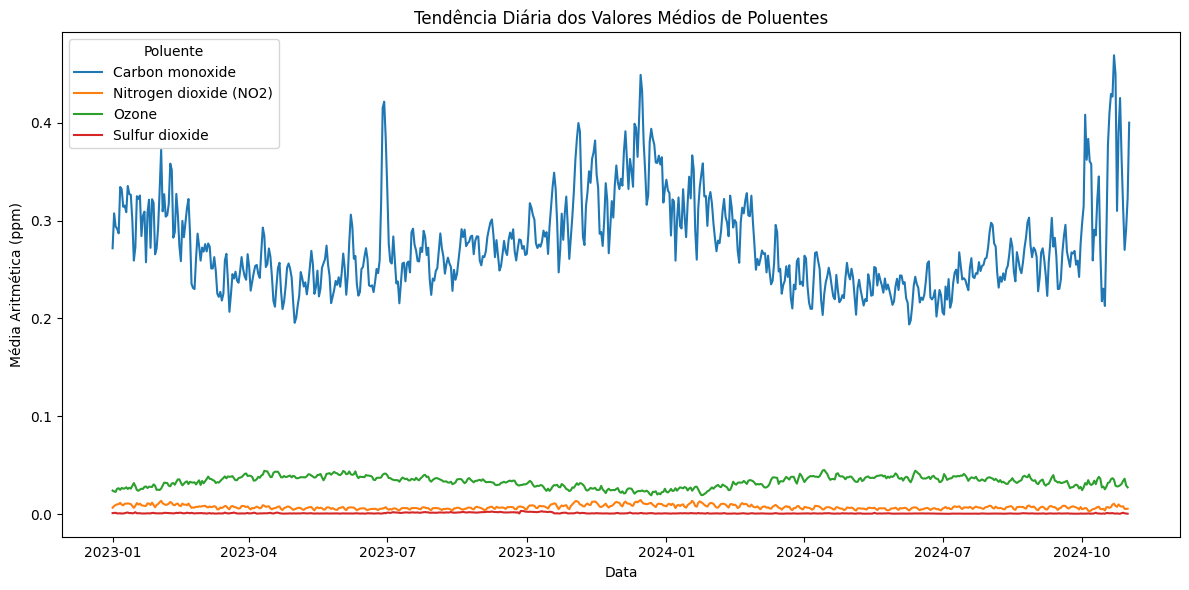

In [144]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_media_geral, x='Date Local', y='Arithmetic Mean', hue='Parameter Name')
plt.title('Tendência Diária dos Valores Médios de Poluentes')
plt.xlabel('Data')
plt.ylabel('Média Aritmética (ppm)')
plt.legend(title='Poluente')
plt.tight_layout()
plt.show()
plt.close()

Vamos ver agora retirando o monóxido de carbono da equação para ver os demais melhor

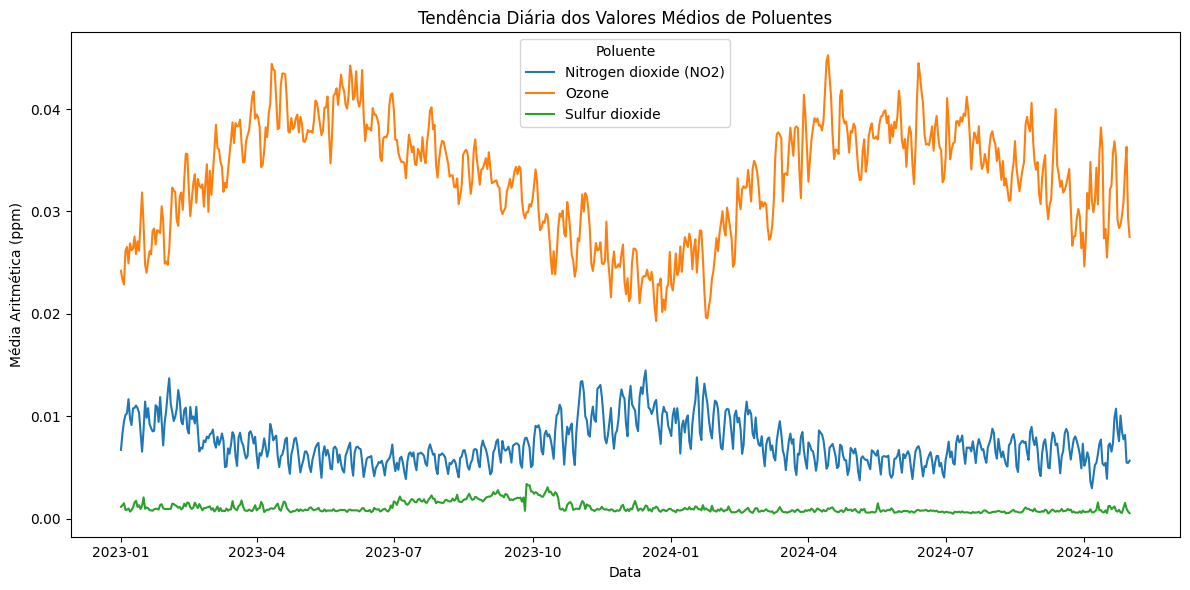

In [145]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_media_geral[df_media_geral['Parameter Name'] != 'Carbon monoxide'], x='Date Local', y='Arithmetic Mean', hue='Parameter Name')
plt.title('Tendência Diária dos Valores Médios de Poluentes')
plt.xlabel('Data')
plt.ylabel('Média Aritmética (ppm)')
plt.legend(title='Poluente')
plt.tight_layout()
plt.show()
plt.close()

## Gráfico 3 - Avaliando Distribuição espacial

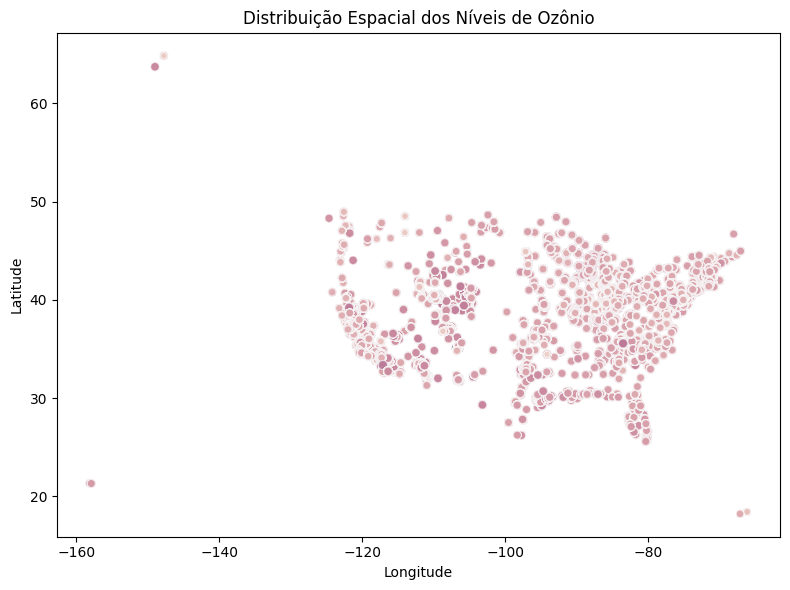

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_all[df_all['Parameter Name'] == 'Ozone'],
    x='Longitude',
    y='Latitude',
    size='Arithmetic Mean',
    hue='Arithmetic Mean',
    alpha=0.6,
    legend=False
)
plt.title('Distribuição Espacial dos Níveis de Ozônio')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()
plt.close()


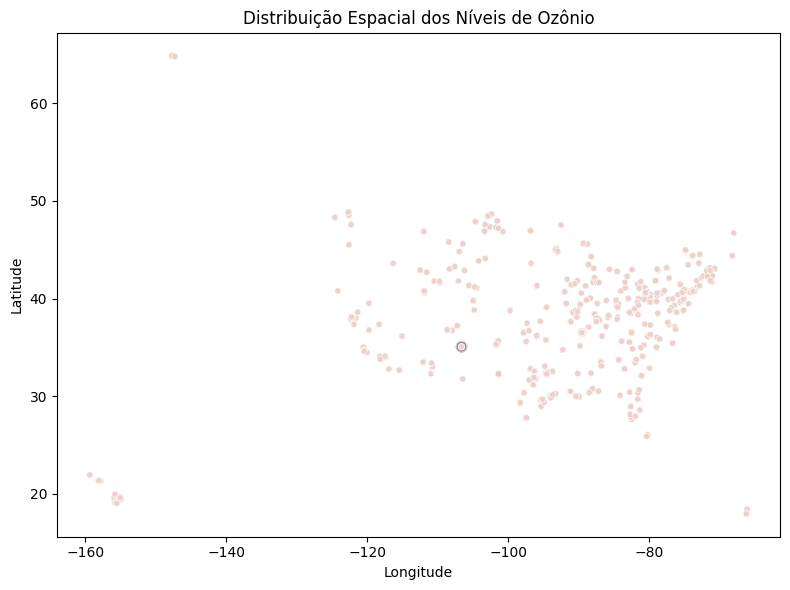

In [148]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_all[df_all['Parameter Name'] == 'Sulfur dioxide'],
    x='Longitude',
    y='Latitude',
    size='Arithmetic Mean',
    hue='Arithmetic Mean',
    alpha=0.6,
    legend=False
)
plt.title('Distribuição Espacial dos Níveis de Ozônio')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()
plt.close()


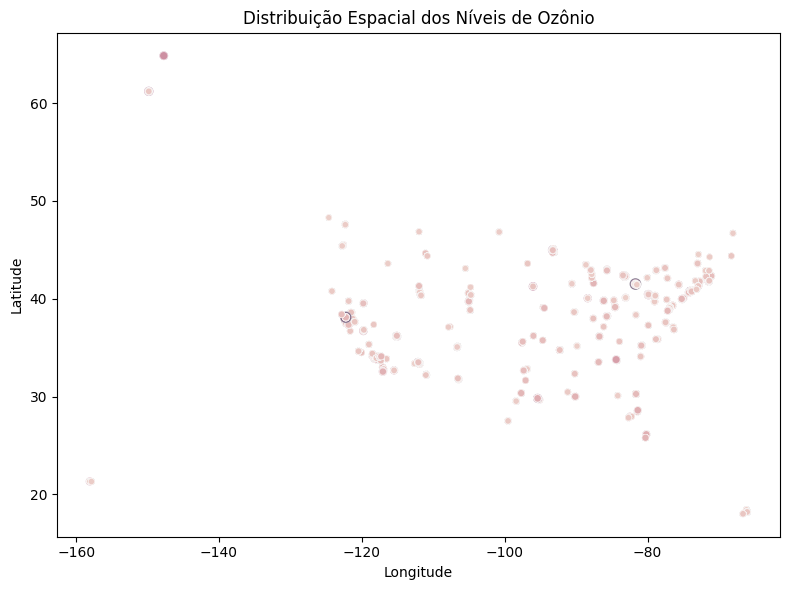

In [149]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_all[df_all['Parameter Name'] == 'Carbon monoxide'],
    x='Longitude',
    y='Latitude',
    size='Arithmetic Mean',
    hue='Arithmetic Mean',
    alpha=0.6,
    legend=False
)
plt.title('Distribuição Espacial dos Níveis de Ozônio')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()
plt.close()


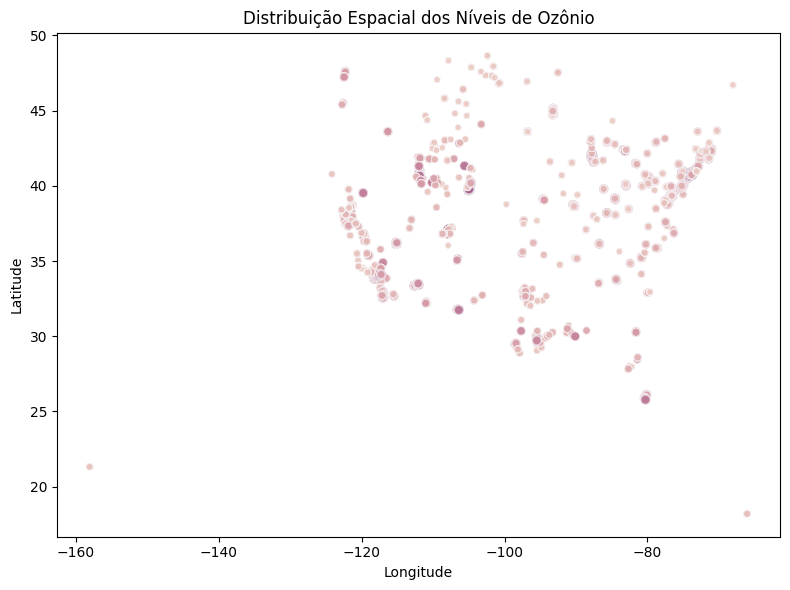

In [150]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_all[df_all['Parameter Name'] == 'Nitrogen dioxide (NO2)'],
    x='Longitude',
    y='Latitude',
    size='Arithmetic Mean',
    hue='Arithmetic Mean',
    alpha=0.6,
    legend=False
)
plt.title('Distribuição Espacial dos Níveis de Ozônio')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()
